# **Final, GROUP 12**

## Members: Xiqing Mao, Zelin Li, Lu Wang

## Scrape Wikinews data with more information
From the "Politics and Conflict" section of the Wikinews 

In [1]:
import requests
from bs4 import BeautifulSoup
import codecs
import csv
import os
import re
from tqdm.notebook import tqdm
import time
import pandas as pd
from newspaper import Article
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/xiqing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
url = 'https://en.wikinews.org/wiki/Category:Politics_and_conflicts'

In [ ]:
# initilize the home page
response = requests.get(url)
contents = response.text
soup = BeautifulSoup(contents, 'html.parser')
current_page = soup.find(id = "mw-pages")
# regexp of "next page" url
reg = r"<a href=\"\/w\/index\.php\?title=Category:Politics_and_conflicts&amp;(pagefrom=[^#]*#mw-pages)\" title=\"Category:Politics and conflicts\">next page</a>"
next_page = re.findall(reg, str(current_page))

In [8]:
wiki_news_path = '/Users/xiqing/Documents/OneDrive/文档/GitHub/DS_project/Final/wiki.csv'

In [ ]:
# write csv header
with codecs.open(wiki_news_path,'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['title','scrape_at','url', 'pub_date', 'content','category','keyword','summary'])
# collect news
while next_page:
  soup = BeautifulSoup(contents, 'html.parser')
  current_page = soup.find(id = "mw-pages")
  news_row = []
  # find news title start with 'MNOPRSTUVW' in current page
  filtered = current_page.findAll(name='a',attrs={"href":re.compile(r'^(\/wiki\/[\s\S]*)')}) #'^(/wiki/[MNOPRSTUVW])')})
  if filtered:
      for i in filtered:
        # news title and url
        title = i.get_text()
        title_url = 'https://en.wikinews.org'+i['href']
        news_page = BeautifulSoup(requests.get(title_url).text, 'html.parser').find(class_="mw-parser-output")
        # publish date
        pub_date = [i.get('title') for i in news_page.findAll(name='span',attrs={"id":re.compile(r'publishDate')})]
        pub_date = ''.join(pub_date)
        # scrape time
        scrape_at = time.strftime("%Y.%m.%d %H:%M:%S", time.localtime())
        # category word
        cat_word = BeautifulSoup(requests.get(title_url).text, 'html.parser').find(class_="catlinks")
        category =[i.get_text() for i in cat_word.findAll(name='a',attrs={"href":re.compile(r'(\/wiki\/Category:)\b(?!Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[\s\S]*[^"]')})]
        category = ','.join(category)
        # use newspaper3k and nlp to generate info about news
        article = Article(title_url)
        article.download()
        article.html
        article.parse()
        article.nlp()
        # content
        content = article.text
        # keyword
        key_word = article.keywords
        # summary
        summary = article.summary
        news_row.append([title, scrape_at, title_url, pub_date, content, category, key_word, summary])
      with codecs.open(wiki_news_path,'a+', encoding='utf-8') as f:
        writer = csv.writer(f)
        for data in news_row:
            writer.writerow(data)
  next_page = re.findall(reg, str(current_page))
  if next_page:
    response = requests.get("https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&" + next_page[0])
    contents = response.text

In [5]:
# read csv
df = pd.read_csv(wiki_news_path)
#df=df.drop(labels=range(0,10),axis=0)
#df=df.reset_index(drop=True)

In [ ]:
# add type
df['type']='political'
# add domain
df['domain']='wikinews.org'
# add domain
df['author']='wikinews'
# save to csv
df.to_csv(wiki_news_path, header=None)

## Load csv file

We have scraped and created a wikinews csv file which has header "id, title, scrape_at, url, pub_date, content, category, keyword, summary, type, domain, author". 


Just like before loading fakenews, we load wiki.csv to table `wikinews`:

```
CREATE TABLE wiknews
(
	id INTEGER,title TEXT,scrape_at timestamp,url TEXT,pub_date DATE,
	content TEXT,category TEXT,keywords TEXT,
	summary TEXT,type TEXT,domain TEXT,author TEXT
);
```

In [4]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from IPython.display import HTML, Math
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default'></script>"))

In [10]:
rootuser = 'admin'
your_pwd = '19980903'
path_input = wiki_news_path # Input data file path
name_Database = 'wikinews'

In [10]:
# Connect to PostgreSQL
con = psycopg2.connect(database="postgres", user=rootuser, password=your_pwd,host="127.0.0.1",port="5432")
con.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
# Create a cursor object using the cursor() method
cur = con.cursor()
# Setup a database with name wikinews
cur.execute("DROP DATABASE IF EXISTS "+name_Database+";")
cur.execute("CREATE DATABASE "+name_Database+";")

con.commit()
con.close()
print("Database \'"+name_Database+"\' created successfully!")

Database 'wikinews' created successfully!


In [12]:
# change to non-root user
con = psycopg2.connect(database=name_Database,user='xq',password=your_pwd,host='127.0.0.1',port='5432')
cur = con.cursor()
# Create a table 'news'
name_table = 'news'
cur.execute('DROP TABLE IF EXISTS '+name_table+';')
cur.execute("CREATE TABLE "+name_table+"(id TEXT,title TEXT,scrape_at timestamp,url TEXT,pub_date TEXT, content TEXT,category TEXT,keywords TEXT,summary TEXT,type TEXT,domain TEXT,author TEXT);")
# Copy data from csv file to database
cur.execute("COPY "+name_table+" FROM \'"+path_input+"\' DELIMITER ',' CSV HEADER;")
# Delete news without 'id' attribute
cur.execute('DELETE FROM '+name_table+' WHERE id IS NULL')
# Delete text in 'id' attribute
cur.execute("DELETE FROM "+name_table+" WHERE id ~* '^[a-zA-Z]|\d*\.\d*'")
# Set INTEGER for id
cur.execute("ALTER TABLE "+name_table+" ALTER COLUMN id TYPE integer USING id::integer")
# Set DATE for pub_date
cur.execute("delete FROM "+name_table+" WHERE CHAR_LENGTH(pub_date)>10")
cur.execute("ALTER TABLE "+name_table+" ALTER COLUMN pub_date TYPE DATE USING pub_date::DATE") 
con.commit()

## Schema design

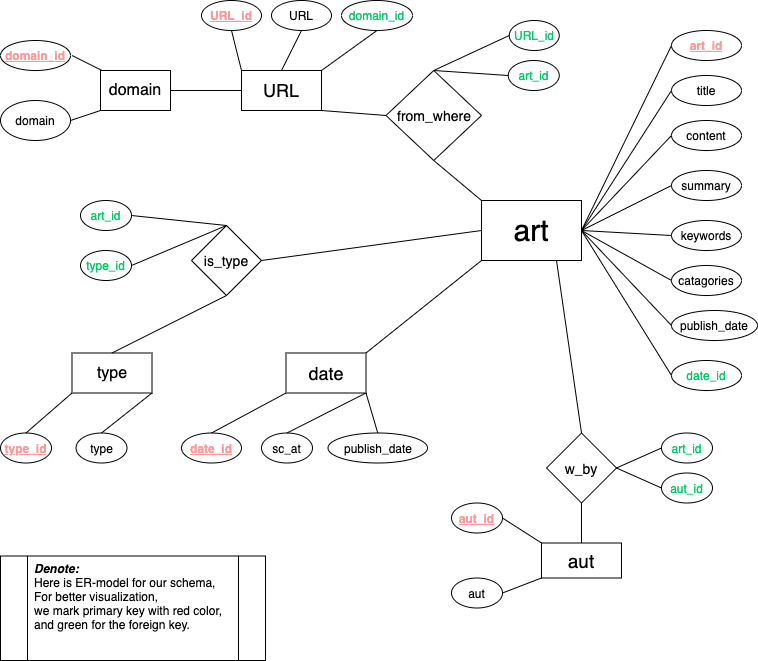

In [32]:
# Connect to pSQL
con = psycopg2.connect(database=name_Database,user='xq',password=your_pwd,host='127.0.0.1',port='5432')
cur = con.cursor()

### **1.1** Creat table `domain`

In [15]:
# create table domain
cur.execute("DROP TABLE IF EXISTS domain")
cur.execute("SELECT id,domain INTO domain FROM "+name_table+";")
# delete duplicate domains
cur.execute('DELETE FROM domain d WHERE d.id NOT IN (SELECT MIN(id) FROM domain GROUP BY domain)')
# drop id
cur.execute('ALTER TABLE domain DROP COLUMN id')
# generate domain_id
cur.execute('ALTER TABLE domain ADD COLUMN d_id SERIAL UNIQUE')
# set domain as Primary key (PK)
cur.execute('ALTER TABLE domain ADD PRIMARY KEY(d_id)')
con.commit()

### **1.2** Creat table `URL`

In [16]:
# create table URL
cur.execute("DROP TABLE IF EXISTS URL")
cur.execute("SELECT id,URL,domain INTO URL FROM "+name_table+";")
# rename id to url_id
cur.execute('ALTER TABLE URL RENAME COLUMN id TO url_id')
# insert domain_id
cur.execute('ALTER TABLE URL ADD column d_id integer')
cur.execute('UPDATE URL SET d_id = domain.d_id FROM domain WHERE URL.domain=domain.domain')
cur.execute('ALTER TABLE URL DROP COLUMN domain')
# set url_id as PK
cur.execute('ALTER TABLE URL ADD PRIMARY KEY (url_id)')
con.commit()

### **1.3** Creat table `date`

In [17]:
# create table date
cur.execute("DROP TABLE IF EXISTS date")
cur.execute("SELECT id,scrape_at,pub_date INTO date FROM "+name_table+";")
# delete duplicate date
cur.execute('DELETE FROM date d WHERE d.id NOT IN (SELECT MIN(id) FROM date GROUP BY scrape_at,pub_date)')
# add date_id
cur.execute('ALTER TABLE date DROP COLUMN id')
cur.execute('CREATE SEQUENCE date_id')
cur.execute("ALTER TABLE date ADD COLUMN date_id integer NOT NULL DEFAULT NEXTVAL('date_id')")
cur.execute('ALTER SEQUENCE date_id OWNED BY date.date_id')
# set date_id as PK
cur.execute('ALTER TABLE date ADD PRIMARY KEY (date_id)')
con.commit()

### **1.4** Creat table `article`

In [23]:
# create table article
cur.execute("DROP TABLE IF EXISTS article")
cur.execute("SELECT id,title,summary,content,scrape_at,pub_date,keywords,category INTO article FROM "+name_table+";")
# insert date_id
cur.execute('ALTER TABLE article ADD column date_id integer')
cur.execute('UPDATE article SET date_id = date.date_id FROM date WHERE article.scrape_at=date.scrape_at AND article.pub_date=date.pub_date')
cur.execute('ALTER TABLE article DROP COLUMN scrape_at, DROP COLUMN pub_date')
# set id as PK
cur.execute('ALTER TABLE article ADD PRIMARY KEY (id)')
# set date_id as foreign key (FK)
cur.execute('ALTER TABLE article ADD CONSTRAINT fk_date FOREIGN KEY (date_id) REFERENCES date(date_id)')
con.commit()

### **1.5** Creat table `from_where`

In [24]:
# create table from_where
cur.execute("DROP TABLE IF EXISTS from_where")
cur.execute("SELECT id INTO from_where FROM "+name_table+";")
cur.execute('ALTER TABLE from_where ADD COLUMN url_id integer')
cur.execute('UPDATE from_where SET url_id=id;')
# set FK
cur.execute('ALTER TABLE from_where ADD CONSTRAINT fk_fromurlid FOREIGN KEY (url_id) REFERENCES URL(url_id)')
cur.execute('ALTER TABLE from_where ADD CONSTRAINT fk_fromartid FOREIGN KEY (id) REFERENCES article(id)')
con.commit()

### **1.6** Creat table `type`

In [25]:
# create table type
cur.execute("DROP TABLE IF EXISTS type")
cur.execute("SELECT id,type into type from "+name_table+";")
# delete duplicate type
cur.execute('DELETE FROM type t WHERE t.id NOT IN (SELECT MIN(id) FROM type GROUP BY type)')
# add type_id
cur.execute('ALTER TABLE type DROP COLUMN id')
cur.execute('CREATE SEQUENCE type_id')
cur.execute("ALTER TABLE type ADD COLUMN type_id integer NOT NULL DEFAULT NEXTVAL('type_id')")
cur.execute('ALTER SEQUENCE type_id OWNED BY type.type_id')
# set type_id as PK
cur.execute('ALTER TABLE type ADD PRIMARY KEY (type_id)')
con.commit()

### **1.7** Creat table `aut`

In [28]:
# create table aut(author)
cur.execute("DROP TABLE IF EXISTS aut")
cur.execute("SELECT id,author INTO aut FROM "+name_table+";")
# delete dup authors
cur.execute('DELETE FROM aut a WHERE a.id NOT IN (SELECT MIN(id) FROM aut GROUP BY author)')
# drop id
cur.execute('ALTER TABLE aut DROP COLUMN id')
# gen aut_id
cur.execute('ALTER TABLE aut add COLUMN aut_id SERIAL UNIQUE')
# set domain as PK
cur.execute('ALTER TABLE aut ADD PRIMARY KEY(aut_id)')
con.commit()

### **1.8** Creat table `w_by`

In [33]:
# create table from_where
cur.execute("DROP TABLE IF EXISTS w_by")
cur.execute("SELECT id,author INTO w_by FROM "+name_table+";")
# insert aut_id
cur.execute('ALTER TABLE w_by ADD COLUMN aut_id integer')
cur.execute('UPDATE w_by SET aut_id = aut.aut_id FROM aut WHERE aut.author=w_by.author')
cur.execute('ALTER TABLE w_by DROP COLUMN author')
# set FK
cur.execute('ALTER TABLE w_by ADD CONSTRAINT fk_autid FOREIGN KEY (aut_id) REFERENCES aut(aut_id)')
cur.execute('ALTER TABLE w_by ADD CONSTRAINT fk_artautid FOREIGN KEY (id) REFERENCES article(id)')
con.commit()

### **1.9** Creat table `is_type`

In [34]:
# create table from_where
cur.execute("DROP TABLE IF EXISTS is_type")
cur.execute("SELECT id,type INTO is_type FROM "+name_table+";")
# insert type_id
cur.execute('ALTER TABLE is_type ADD COLUMN type_id integer')
cur.execute('UPDATE is_type SET type_id=type.type_id FROM type WHERE is_type.type=type.type')
cur.execute('ALTER TABLE is_type DROP COLUMN type')
# set FK
cur.execute('ALTER TABLE is_type ADD CONSTRAINT fk_typeid FOREIGN KEY (type_id) REFERENCES type(type_id)')
cur.execute('ALTER TABLE is_type ADD CONSTRAINT fk_arttypeid FOREIGN KEY (id) REFERENCES article(id)')
con.commit()

In [35]:
con.close()

## Basic statistics

In [42]:
# Connect to pSQL
con = psycopg2.connect(database=name_Database,user='xq',password=your_pwd,host='127.0.0.1',port='5432')
cur = con.cursor()

In [43]:
# Count news number
cur.execute('SELECT COUNT(id) FROM '+name_table)
all_news=cur.fetchall()
print(all_news[0][0],'news in total')

7573 news in total


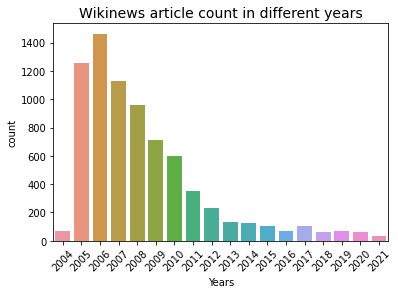

In [75]:
# Distribution over years
cur.execute("create view year_count as SELECT date_trunc('year', pub_date) AS year_group, count(id) as annually_count FROM article INNER JOIN date USING(date_id) GROUP BY year_group")
cur.execute("SELECT extract(year from year_group), annually_count from year_count")
year_count = pd.DataFrame(cur.fetchall(), columns=['years', 'count'])
year_count['years']=year_count['years'].astype('int64')

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.barplot(x="years", y='count',data=year_count)
ax.set_title('Wikinews article count in different years', fontsize = 14)
ax.set_xlabel('Years')
#plt.xticks(rotation = '30')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show();